In [1]:
install.packages('nortest')
install.packages('carData')
library(ggplot2)
library(car)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


#### 6.1
An engineer is interested in the effects of cutting speed(A), tool geometry (B), and cutting angle (C) on the life (in hours) of a machine tool. Two levels of dach factor are chosen, and three replicates of a 2^3 factorial design are run. The results are stored in a file.

* estimate the factor effects. Which effects appear to be large?
* Use the analysis of variance to confirm your conclusion for a
* Write down a regression model for predicting tool life (in fours) based on the results of this experiment. 
* Analyze the residuals. Are there any obvious problems?
* On the basis of an analysis of main effect and interaction plts, what coded factor levels of A, B, and C would you recommend using?

In [2]:
#recode the data: x=1 at level +; X=-1 at level -
coded=function(x) #a function to code variable x
{
  ifelse(x=="+", 1, -1)
}

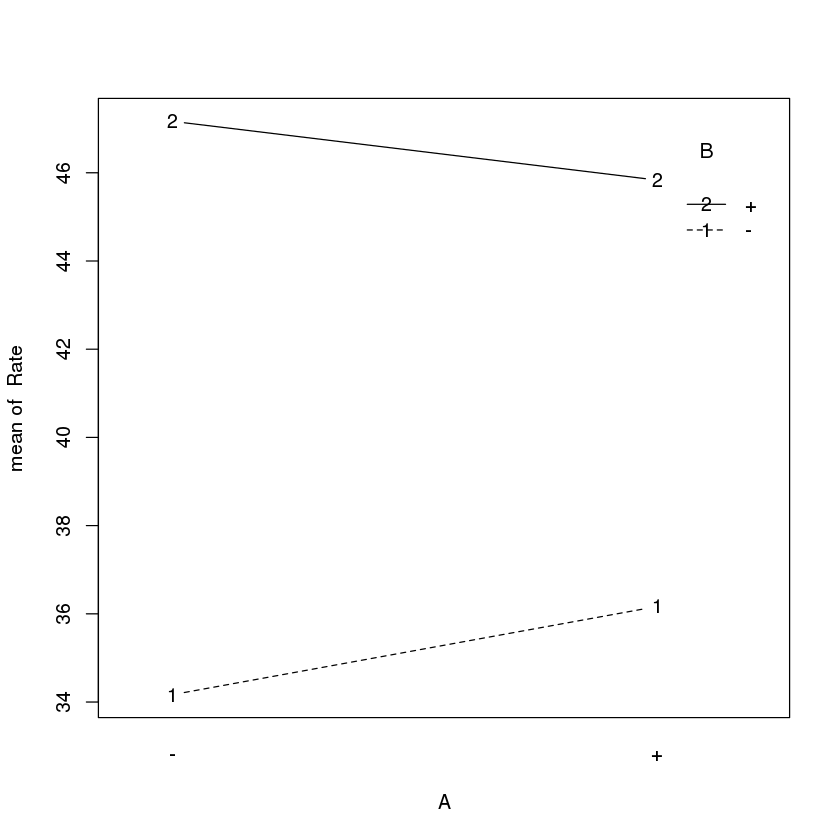

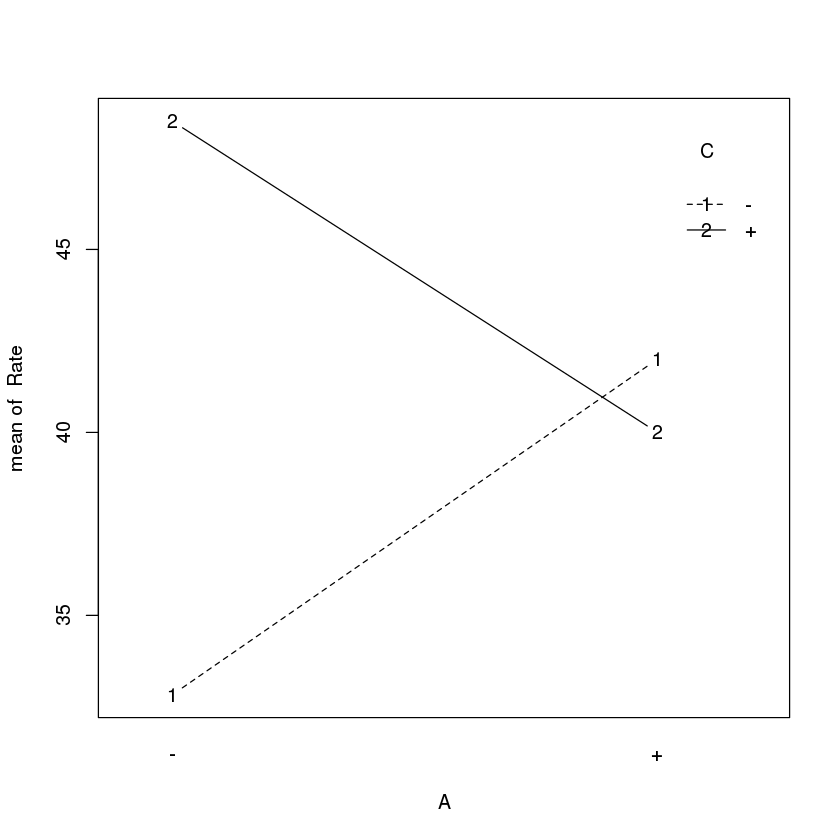

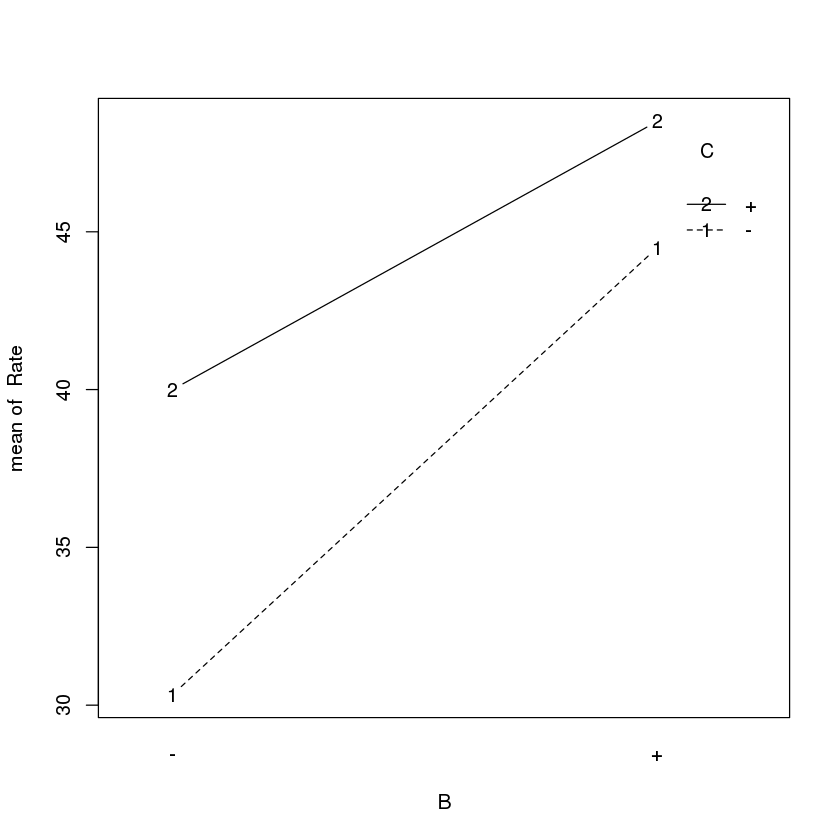

In [3]:

#################################
##     2^3    design            #
#################################
tool = read.table("./data/hw6_p1.txt", header = TRUE)
toolLong=reshape(tool, varying = c("Rep1", "Rep2", "Rep3"), 
                 v.names = "Rate", timevar = "Rep", direction = "long")
#interaction plot
with(toolLong, interaction.plot(A, B, Rate, type = "b"))
with(toolLong, interaction.plot(A, C, Rate, type = "b"))
with(toolLong, interaction.plot(B, C, Rate, type = "b"))


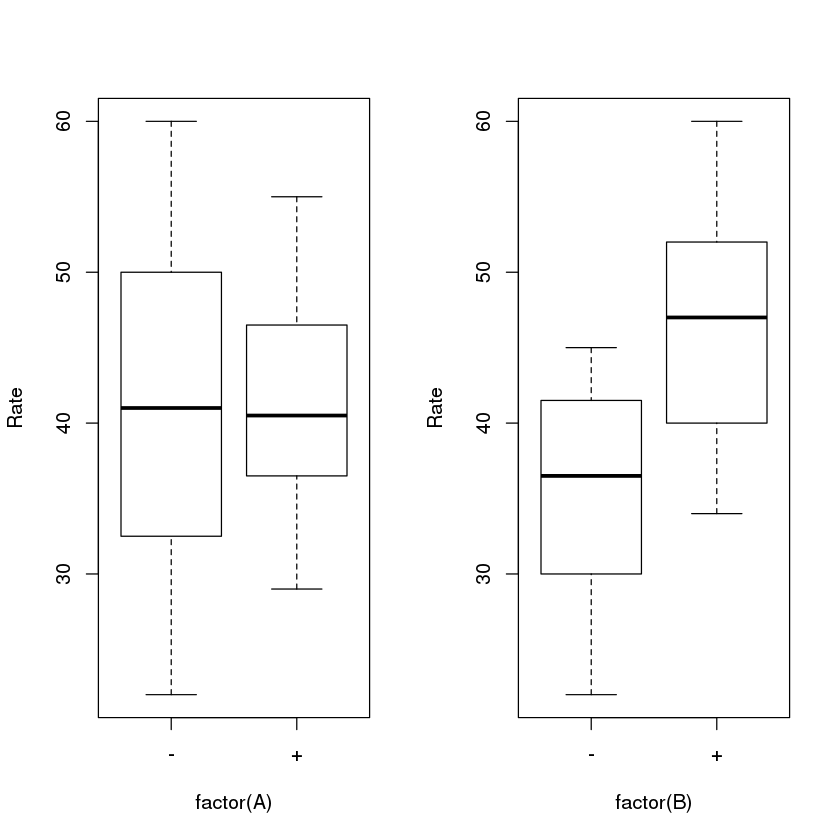

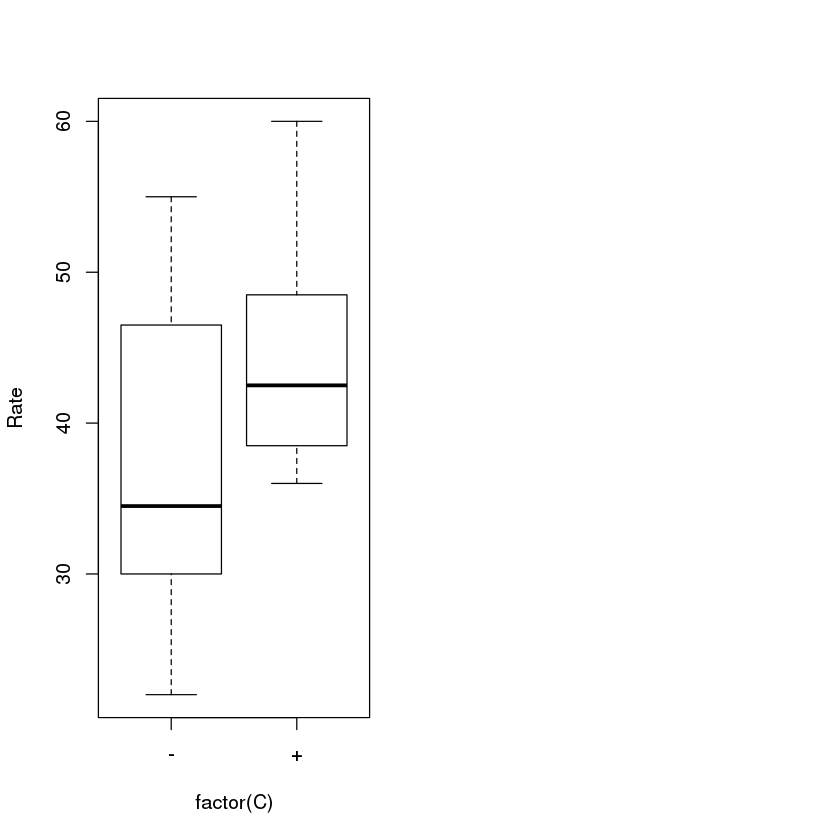

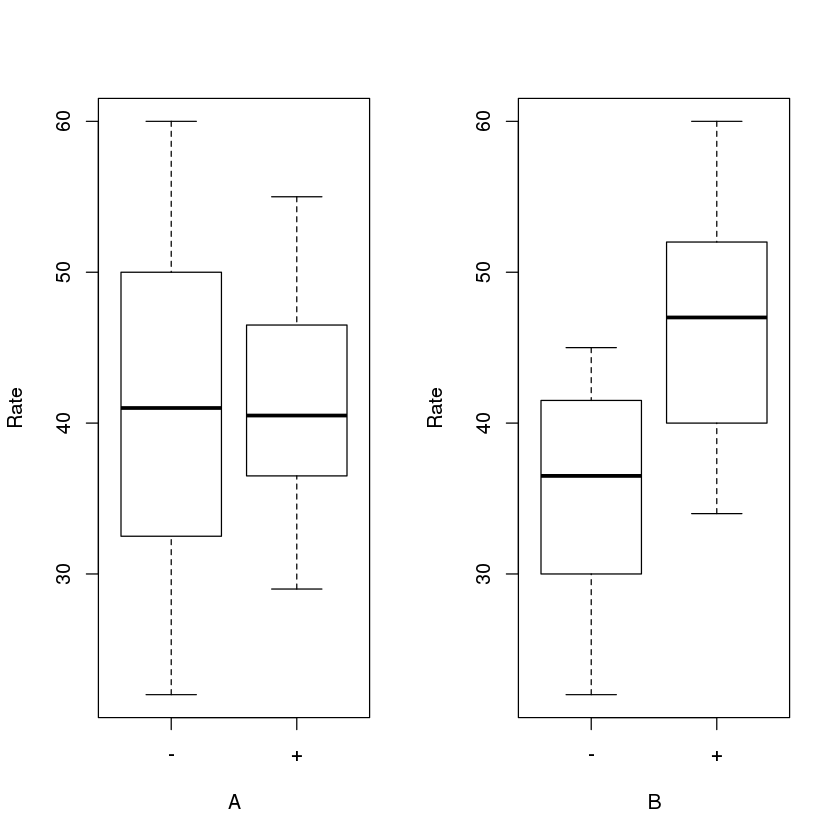

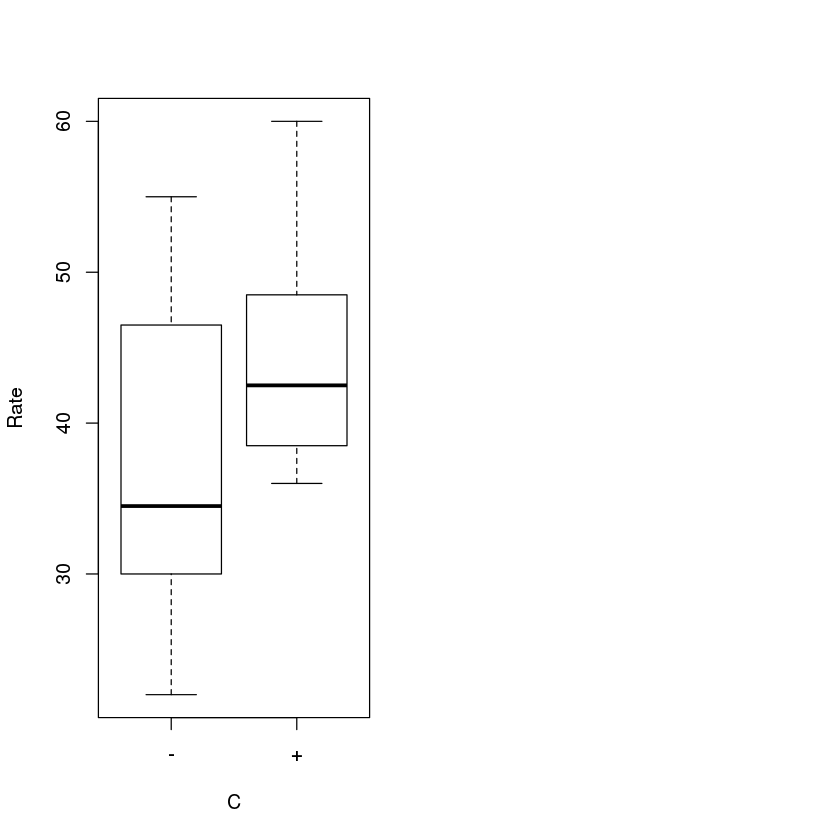

In [4]:
#factor effects
par(mfcol = c(1, 2))
plot(Rate ~ factor(A) + factor(B) + factor(C), data = toolLong)
par(mfrow=c(1,1))

par(mfrow = c(1, 2))
plot(Rate ~ A * B * C, toolLong)


In [5]:
#aova
tool.aov=aov(Rate ~ A * B * C, toolLong)
summary(tool.aov)
mse=summary(tool.aov)[[1]][8,3]
mse

#connection to linear regression
tool.lm=lm(Rate ~ coded(A) * coded(B) * coded(C), toolLong)
summary(tool.lm)


            Df Sum Sq Mean Sq F value   Pr(>F)    
A            1    0.7     0.7   0.022 0.883680    
B            1  770.7   770.7  25.547 0.000117 ***
C            1  280.2   280.2   9.287 0.007679 ** 
A:B          1   16.7    16.7   0.552 0.468078    
A:C          1  468.2   468.2  15.519 0.001172 ** 
B:C          1   48.2    48.2   1.597 0.224475    
A:B:C        1   28.2    28.2   0.934 0.348282    
Residuals   16  482.7    30.2                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] 30.16667


Call:
lm(formula = Rate ~ coded(A) * coded(B) * coded(C), data = toolLong)

Residuals:
   Min     1Q Median     3Q    Max 
-5.667 -3.500 -1.167  3.167 10.333 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 40.8333     1.1211  36.421  < 2e-16 ***
coded(A)                     0.1667     1.1211   0.149 0.883680    
coded(B)                     5.6667     1.1211   5.054 0.000117 ***
coded(C)                     3.4167     1.1211   3.048 0.007679 ** 
coded(A):coded(B)           -0.8333     1.1211  -0.743 0.468078    
coded(A):coded(C)           -4.4167     1.1211  -3.939 0.001172 ** 
coded(B):coded(C)           -1.4167     1.1211  -1.264 0.224475    
coded(A):coded(B):coded(C)  -1.0833     1.1211  -0.966 0.348282    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.492 on 16 degrees of freedom
Multiple R-squared:  0.7696,	Adjusted R-squared:  0.6689 
F-statistic: 7.637 on 7 and 16 

3.3 2.2 
 19  10

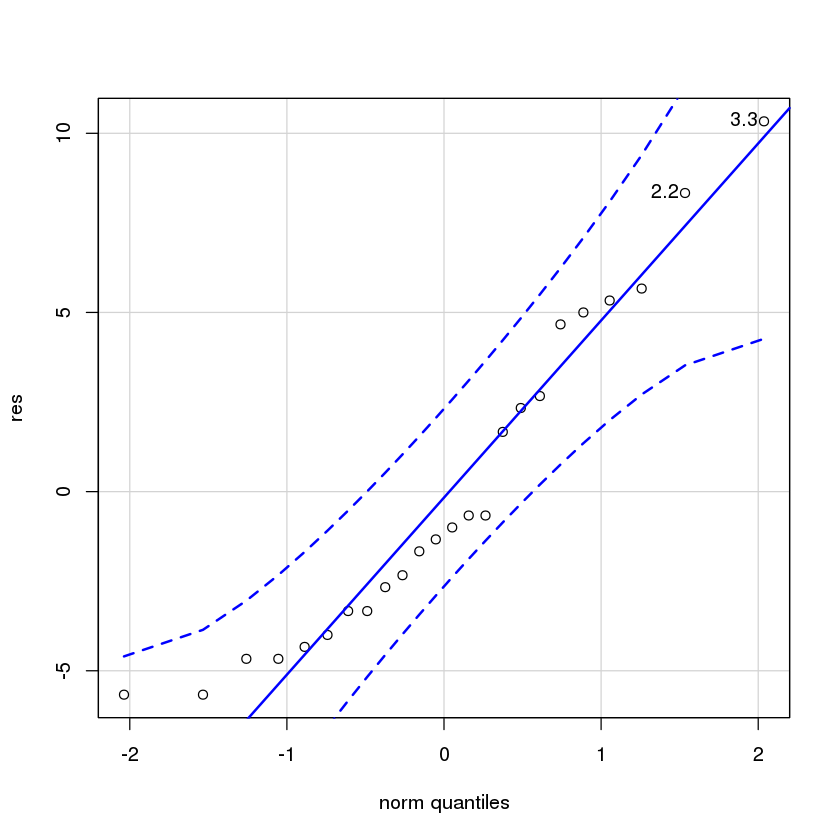

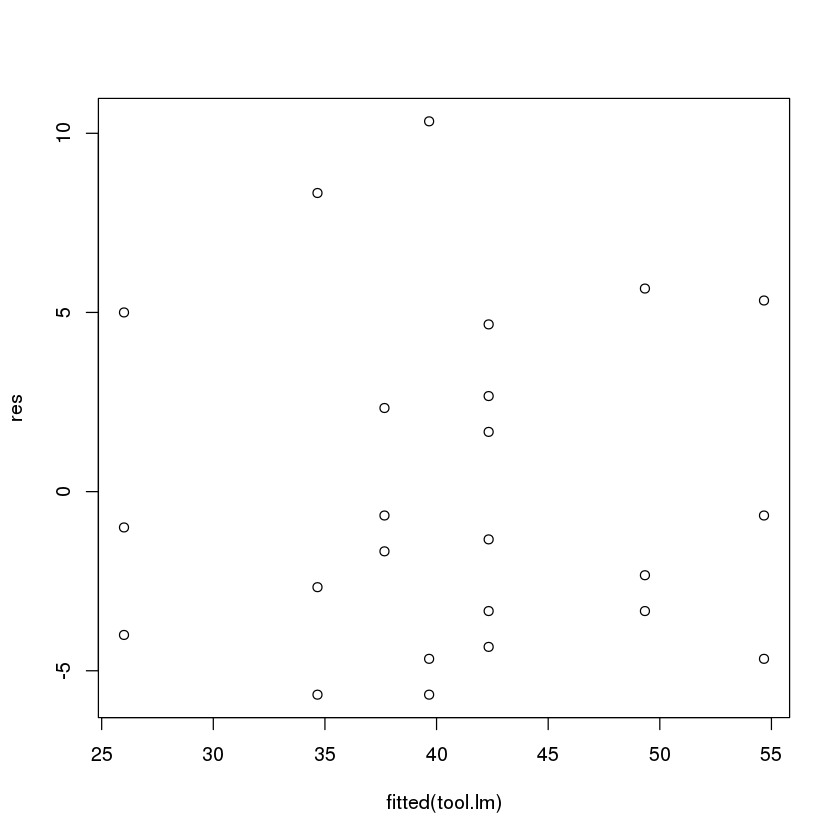

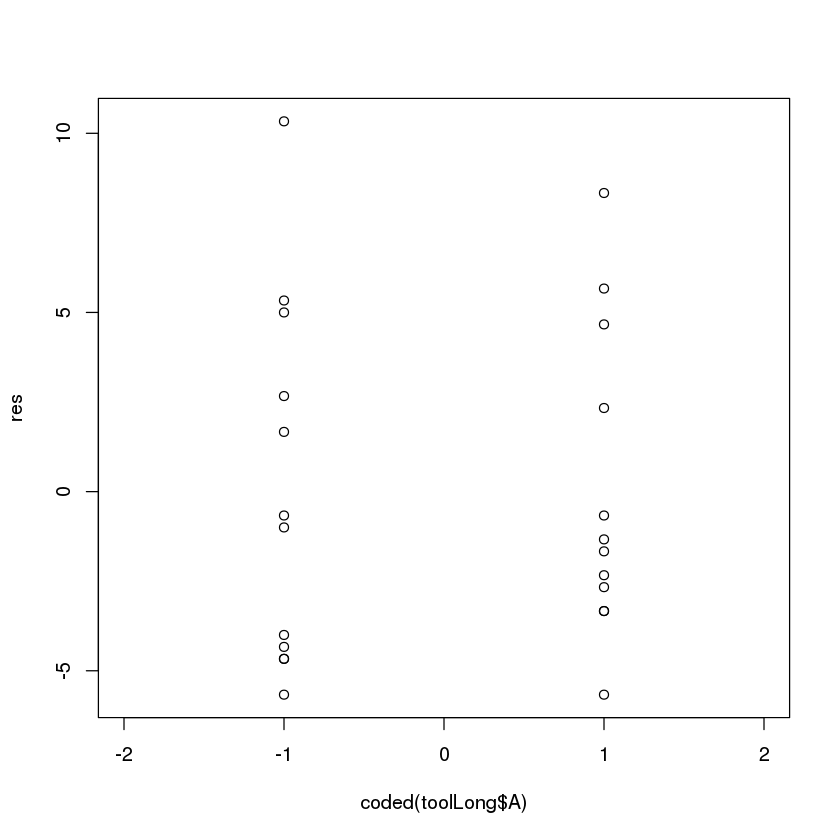

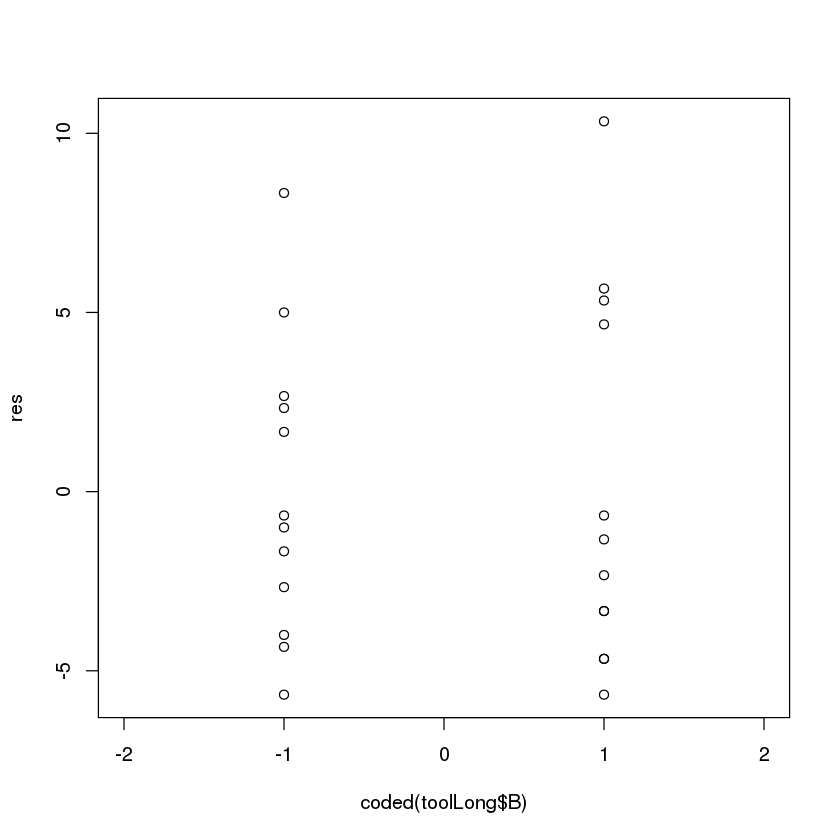

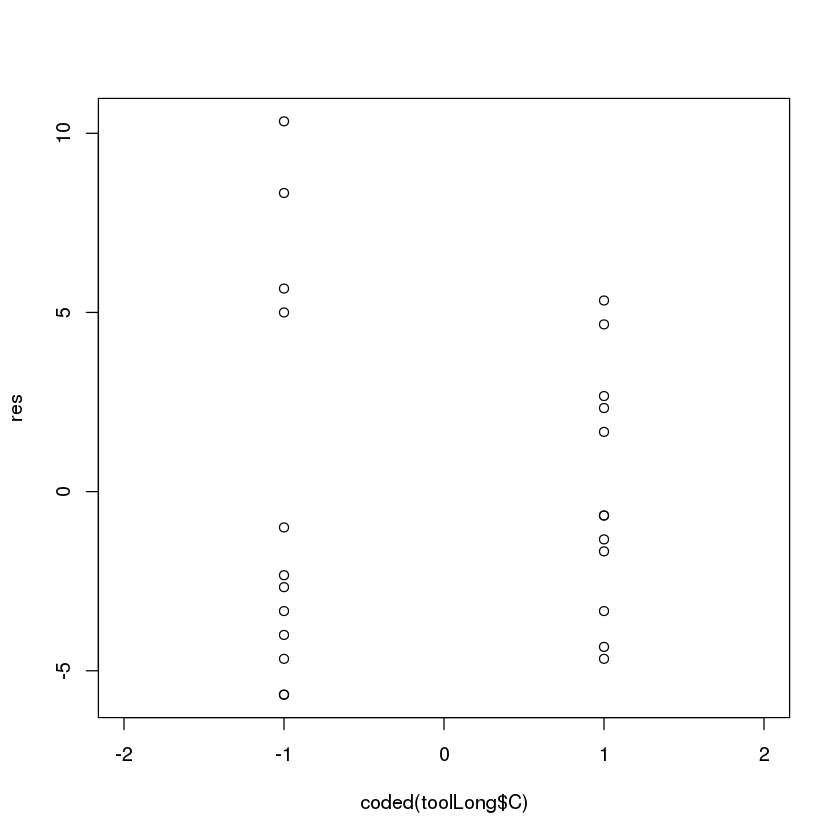

In [6]:
#Model adequacy checking

#residual plots
# r = tool$tool-fitted(tool.lm)
res = toolLong$Rate-fitted(tool.lm)
qqPlot(res)
plot(fitted(tool.lm), res) 
plot(coded(toolLong$A), res, xlim=c(-2,2))
plot(coded(toolLong$B), res, xlim=c(-2,2))
plot(coded(toolLong$C), res, xlim=c(-2,2))

[1] 0.6102688

[1] -1.056849  1.390182

[1] -2.113697  2.780364

[1] -2.0568486  0.3901819

[1] -4.1136971  0.7803638

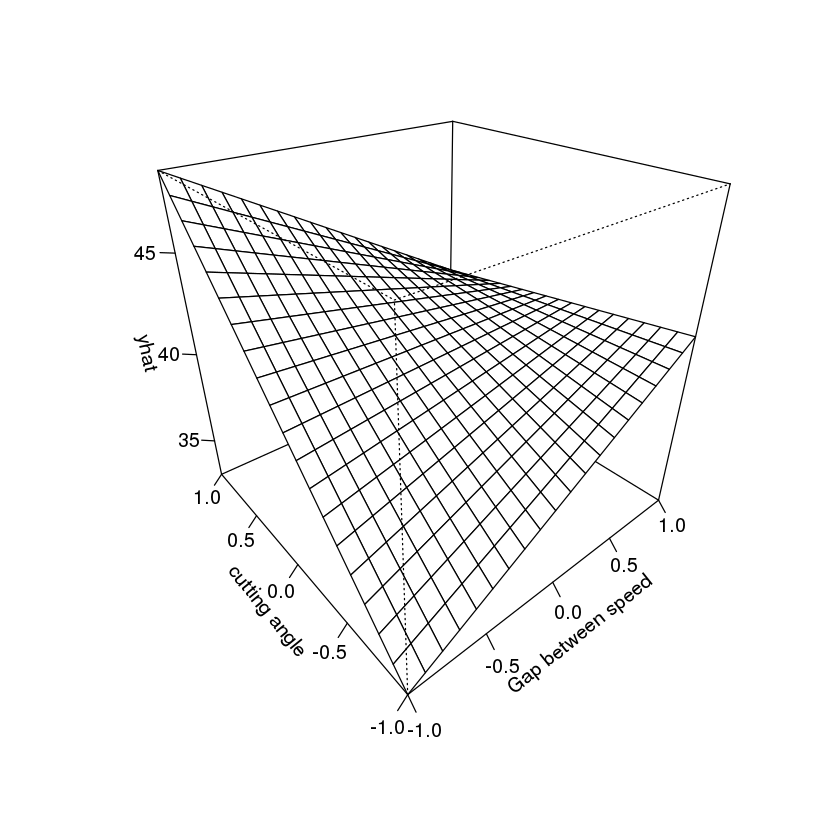

In [7]:
#checking Standard error=sqrt(mse/N)
n=3;a=b=c=3;N=a*b*c*n
alpha=0.05
sqrt(mse/N)
#consturct CI for regression coefficient (example, for coded(A))
se=sqrt(mse/N)
df=a*b*c*(n-1)
hat.beta1=tool.lm$coefficients[2]
CI.beta=hat.beta1+c(-1,1)*qt(alpha/2,df,lower.tail = F)*se
CI.beta
2*CI.beta #CI for main effect A
#CI for AB interaction term coded(A)*coded(B)
hat.beta=tool.lm$coefficients[5]
CI.beta=hat.beta+c(-1,1)*qt(alpha/2,df,lower.tail = F)*se
CI.beta
2*CI.beta #CI for main effect AB

##create response surfaces
toolLong=within(toolLong, {cA = coded(A); cB = coded(B); cC = coded(C)}) 
tool.lm1=lm(Rate ~ cA+cC+cA*cC, toolLong)
ngrid=20
u=1
Agrid=seq(from = -u, to = u, length = ngrid)
Cgrid=seq(from = -u, to = u, length = ngrid)
grid=expand.grid(cA=Agrid, cC=Cgrid)
yhat=predict(tool.lm1, grid)
yhat=matrix(yhat, length(Agrid), length(Cgrid))
persp(Agrid, Cgrid, yhat, theta = -40, phi = 30,
      ticktype = "d", xlab = "Gap between speed", ylab = "cutting angle")
# in real values:


#### 6.3. Find the standard error of the factor effects and approximate 95 percent confidence limits for the factor effects in Problem 6.1. Do the results of this analysis agree with the conclusions from the analysis of variance?

            Df Sum Sq Mean Sq F value  Pr(>F)   
factor(A)    1    0.7     0.7   0.013 0.91114   
factor(B)    1  770.7   770.7  14.766 0.00102 **
factor(C)    1  280.2   280.2   5.368 0.03123 * 
Residuals   20 1043.8    52.2                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] 40.83333

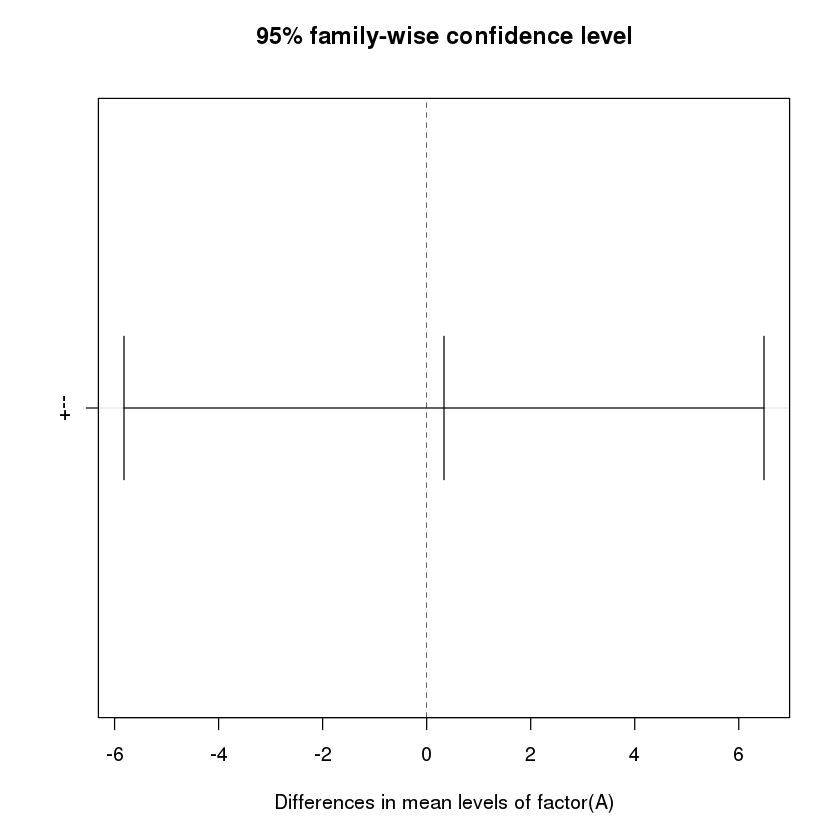

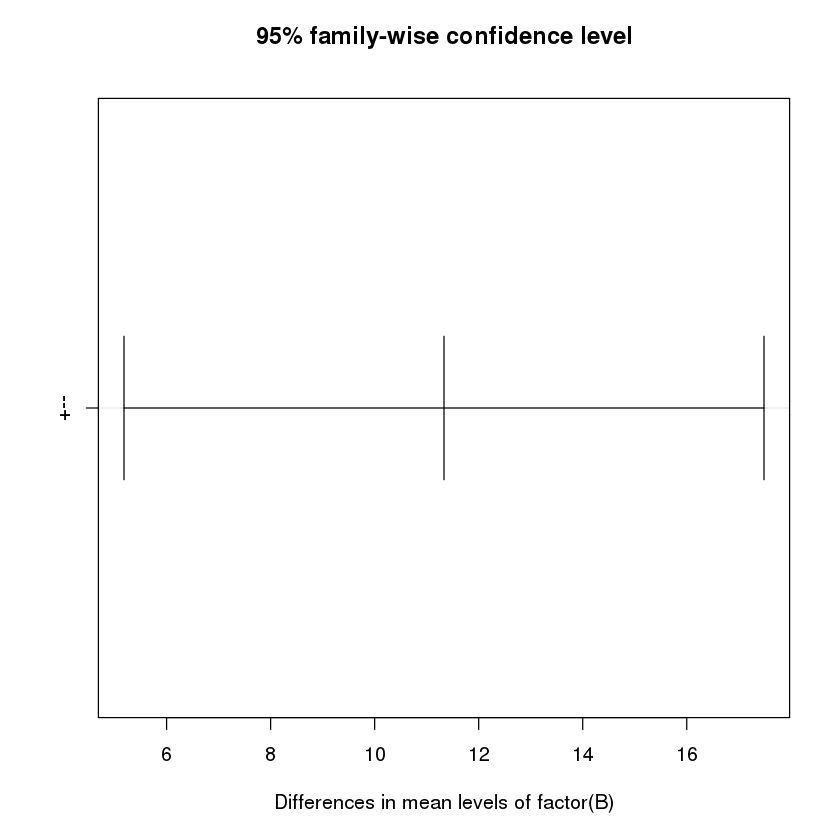

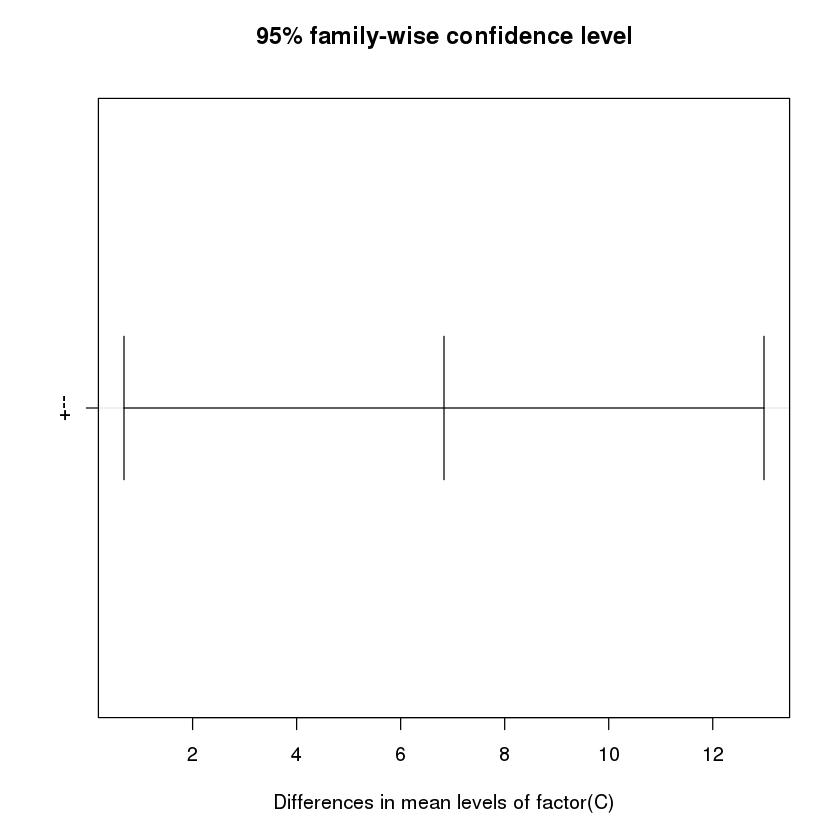

In [8]:
#################################
#  ANOVA test and estimation    #
#################################
#ANOVA analysis
tool.aov = aov(Rate ~ factor(A) + factor(B) + factor(C), data = toolLong)
summary(tool.aov)
MSe=summary(tool.aov)[[1]][3,3]

#Esimation of the model parameters
#estimate of overall mean mu
overall.mean=mean(toolLong$Rate)
overall.mean

ybar.trt=as.vector(with(toolLong, tapply(Rate,Rep,function(x) mean(x)))) #bar(Y_i.) vector
#Tukey's method (for comparing all possible pairwise means)
tool.TK=TukeyHSD(tool.aov)
plot(tool.TK)

#### 6.5. A router is used to cut locating notches on a printed circuit board. The vibration level at the surface of the board as it is cut is considered to be a major source of dimensional variation in the notches. Two factors are thought to influence vibration: bit size and cutting speed. Two bit sizes and two cutting speeds are selected, and four boards are cut at each set of condidtion. The response variable is vibration measured as the reultant vector of theree acceleromteres (x,y,z).

Warning message in read.table("./data/hw6_p5.txt", header = TRUE):
“incomplete final line found by readTableHeader on './data/hw6_p5.txt'”


Call:
lm(formula = Rate ~ cA * cB, data = routLong)

Residuals:
   Min     1Q Median     3Q    Max 
-3.975 -1.550 -0.200  1.200  3.625 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  23.8500     0.6096  39.123 5.02e-14 ***
cA            8.3000     0.6096  13.615 1.17e-08 ***
cB            3.7875     0.6096   6.213 4.50e-05 ***
cA:cB         4.3375     0.6096   7.115 1.22e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.438 on 12 degrees of freedom
Multiple R-squared:  0.9581,	Adjusted R-squared:  0.9477 
F-statistic: 91.53 on 3 and 12 DF,  p-value: 1.552e-08


            Df Sum Sq Mean Sq F value   Pr(>F)    
A            1 1102.2  1102.2  185.37 1.17e-08 ***
B            1  229.5   229.5   38.60 4.50e-05 ***
A:B          1  301.0   301.0   50.62 1.22e-05 ***
Residuals   12   71.4     5.9                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Call:
lm(formula = Rate ~ cA * cB, data = routLong)

Residuals:
   Min     1Q Median     3Q    Max 
-3.975 -1.550 -0.200  1.200  3.625 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  23.8500     0.6096  39.123 5.02e-14 ***
cA            8.3000     0.6096  13.615 1.17e-08 ***
cB            3.7875     0.6096   6.213 4.50e-05 ***
cA:cB         4.3375     0.6096   7.115 1.22e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.438 on 12 degrees of freedom
Multiple R-squared:  0.9581,	Adjusted R-squared:  0.9477 
F-statistic: 91.53 on 3 and 12 DF,  p-value: 1.552e-08


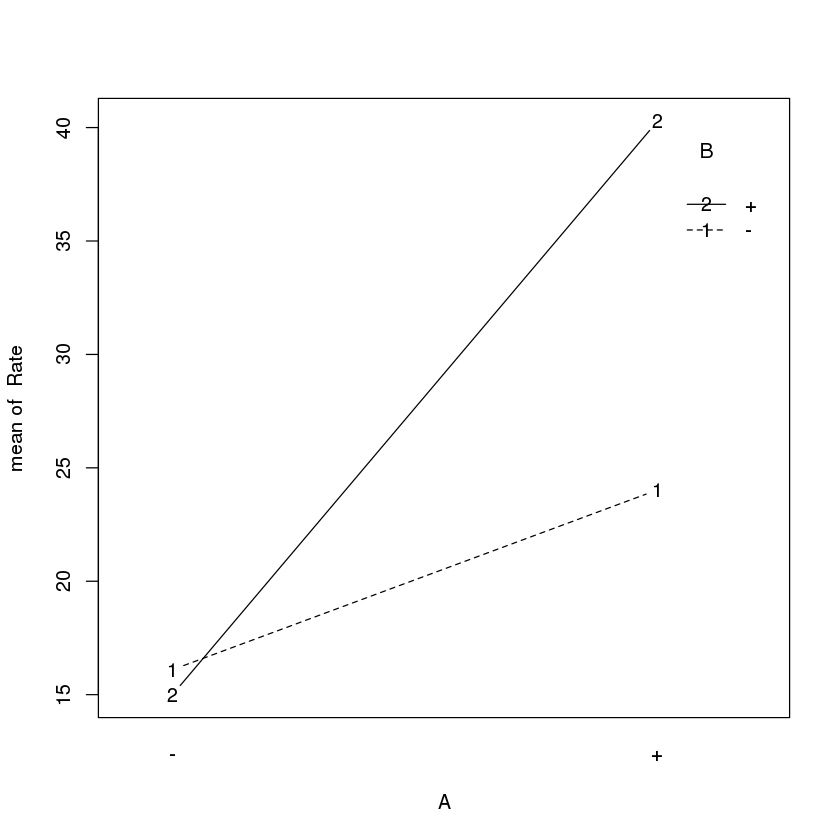

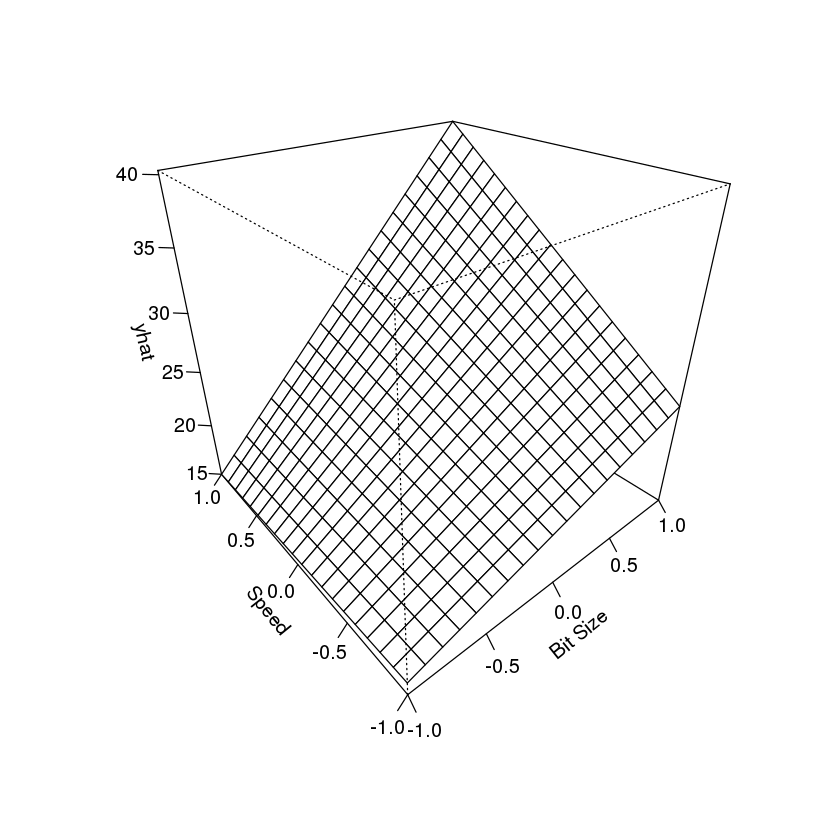

In [9]:
#################################
##     2 by 2 design            #
#################################
# router data (pp. 234)
rout = read.table("./data/hw6_p5.txt", header = TRUE)
routLong=reshape(rout, varying = c("Rep1", "Rep2", "Rep3", "Rep4"), v.names = "Rate",
                      direction = "long", timevar = "Rep")

#interaction plot
with(routLong, interaction.plot(A, B, Rate, type = "b"))


routLong = within(routLong, {cA = coded(A); cB = coded(B)}) #adding two columns to the data frame

#fitting in linear regression
rout.lm=lm(Rate ~ cA * cB, routLong)  
summary(rout.lm)

#ANOVA analysis
summary(aov(Rate ~ A * B, routLong))


#generate response surface
rout.lm1=lm(Rate ~ cA+cB, routLong)  
rout.lm1=rout.lm
summary(rout.lm1)
ngrid=20
Agrid=seq(from = -1, to = 1, length = ngrid)
Bgrid=seq(from = -1, to = 1, length = ngrid)
grid=expand.grid(cA=Agrid, cB=Bgrid)
yhat=predict(rout.lm1, grid)
yhat=matrix(yhat, length(Agrid), length(Bgrid))
persp(Agrid, Bgrid, yhat, theta = -40, phi = 30,
      ticktype = "d", xlab = "Bit Size", ylab = "Speed")


#### 6.6. Reconsider the experiment in 6.1. Suppose that the experimenter only performed the eight trials from replication. In addition, he ran four center points and obtained the following response values: 36, 40, 43, 45.
* Estimate the factor effects. Which effects are large?
* Perform an analysis of variance, including a check for pure quadratic curvature. What are your conclusions?
* Write down an appropriate model for predicting tool life, based on the results of this experiment. Does this model differ in any substantial way from teh model in 6.1?
* Analyze the residuals.
* What conclusions would you draw about the appropriate operating conditions for this process?

#### 6.10. An engineer was interested in potential fatigue differences resulting from the two types of bottles. As a measure of the amount of effort required, he measured the elevation of the heart rate (pulse) induced by the task. The results follow. Ana data and draw conclusions. Analyze the residuals and comment on the model's adequacy.

In [10]:
#################################
##     2^2    design            #
#################################
bottle = read.table("./data/hw6_p10.txt", header = TRUE)
bottleLong=reshape(bottle, varying = c("Wk1", "Wk2"), 
                     v.names = "Rate", timevar = "Wk", direction = "long")

In [11]:
#fitting in linear regression
bottle=within(bottle, {cG = coded(G); cP = coded(P)}) #adding two columns to the data frame
bottle.lm=lm(Rate ~ coded(G) * coded(P), bottleLong)  
summary(bottle.lm)

#ANOVA analysis
summary(aov(Rate ~ G * P, bottleLong))



Call:
lm(formula = Rate ~ coded(G) * coded(P), data = bottleLong)

Residuals:
   Min     1Q Median     3Q    Max 
-18.62 -12.03  -6.00  11.72  28.38 

Coefficients: (2 not defined because of singularities)
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)         27.062      3.881   6.973 6.52e-06 ***
coded(G)             2.563      3.881   0.660     0.52    
coded(P)                NA         NA      NA       NA    
coded(G):coded(P)       NA         NA      NA       NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.52 on 14 degrees of freedom
Multiple R-squared:  0.0302,	Adjusted R-squared:  -0.03907 
F-statistic: 0.436 on 1 and 14 DF,  p-value: 0.5198


            Df Sum Sq Mean Sq F value Pr(>F)
G            1    105   105.1   0.436   0.52
Residuals   14   3374   241.0               

3.1 5.1 
  3   5

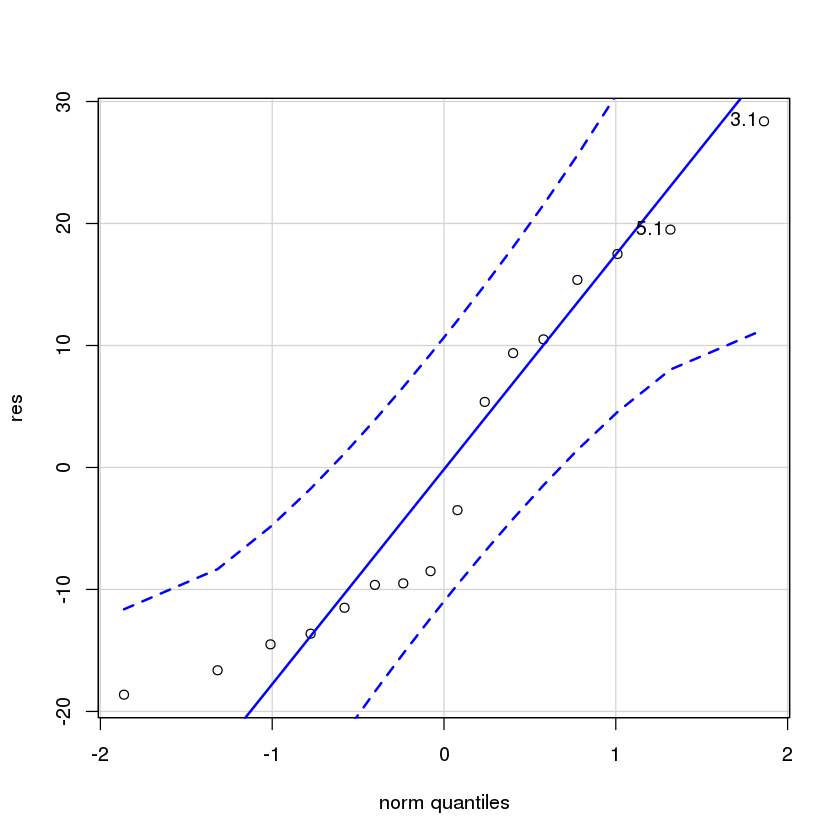

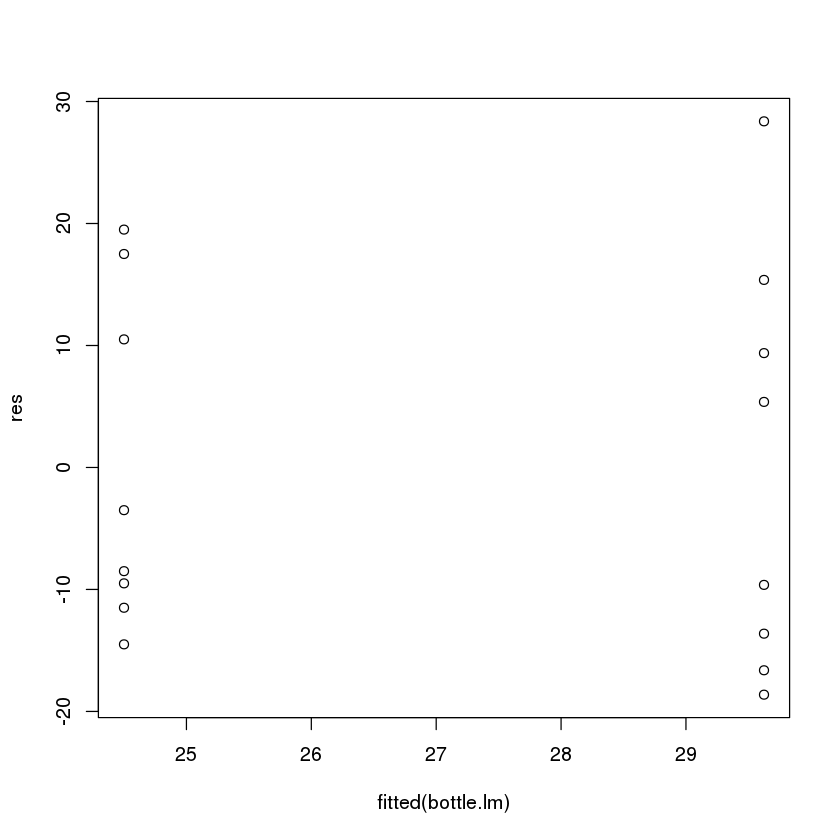

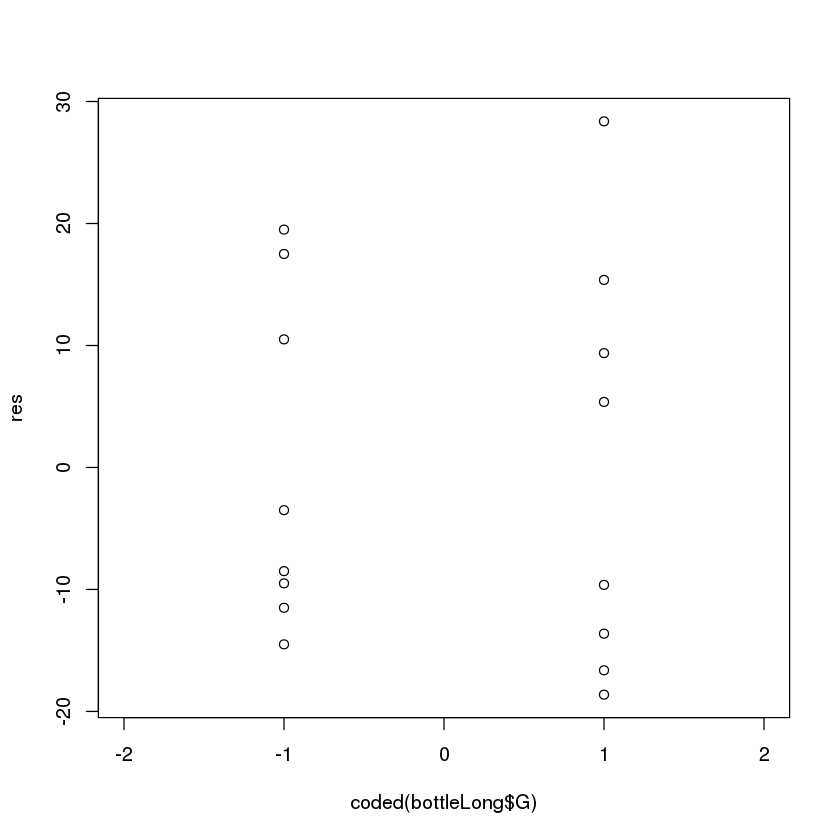

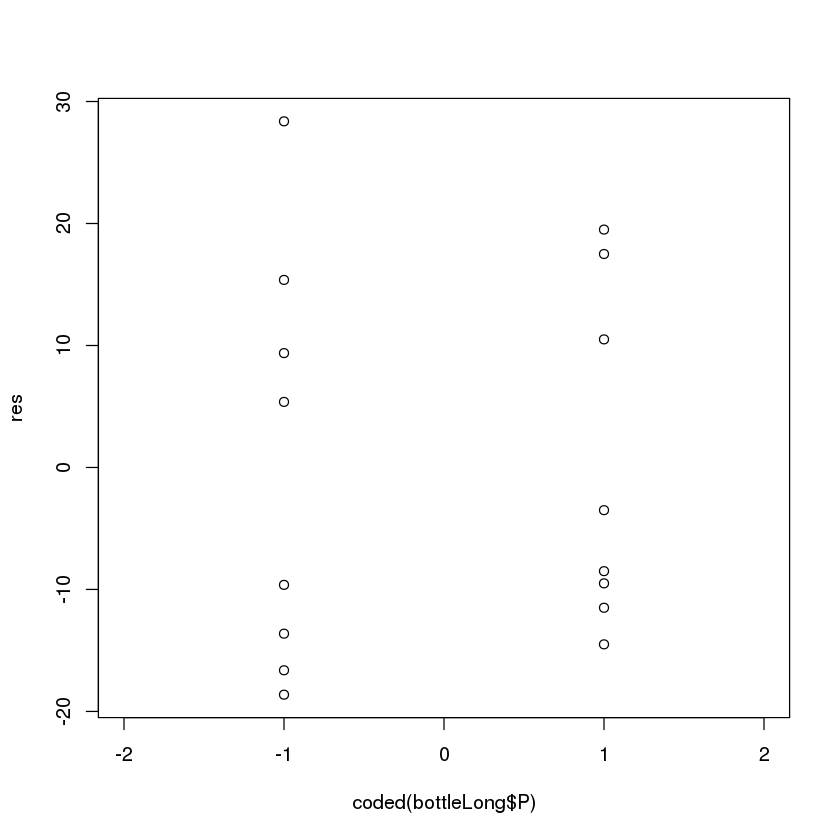

In [12]:


#Model adequacy checking
res=bottleLong$Rate-fitted(bottle.lm)
qqPlot(res)
plot(fitted(bottle.lm), res) 
plot(coded(bottleLong$G), res, xlim=c(-2,2))
plot(coded(bottleLong$P), res, xlim=c(-2,2))


#### 6.17. An experimenter has run a single replicate of a 2^4 design.
* construct a normal probability plot of these effects.
* Identify a tentative model based on the plot of the effects in part (a).

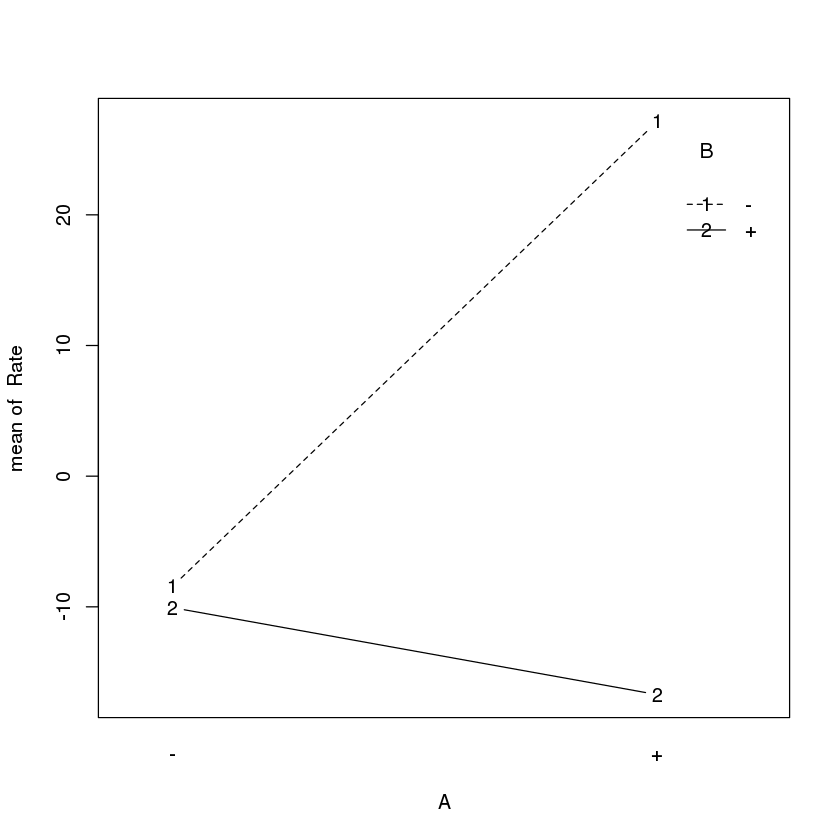

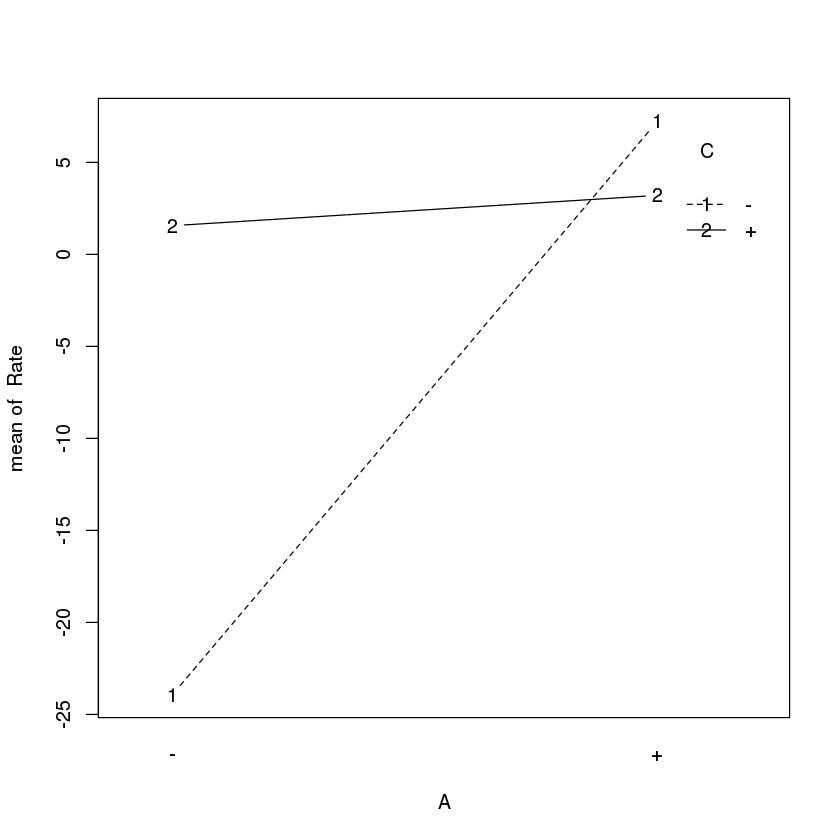

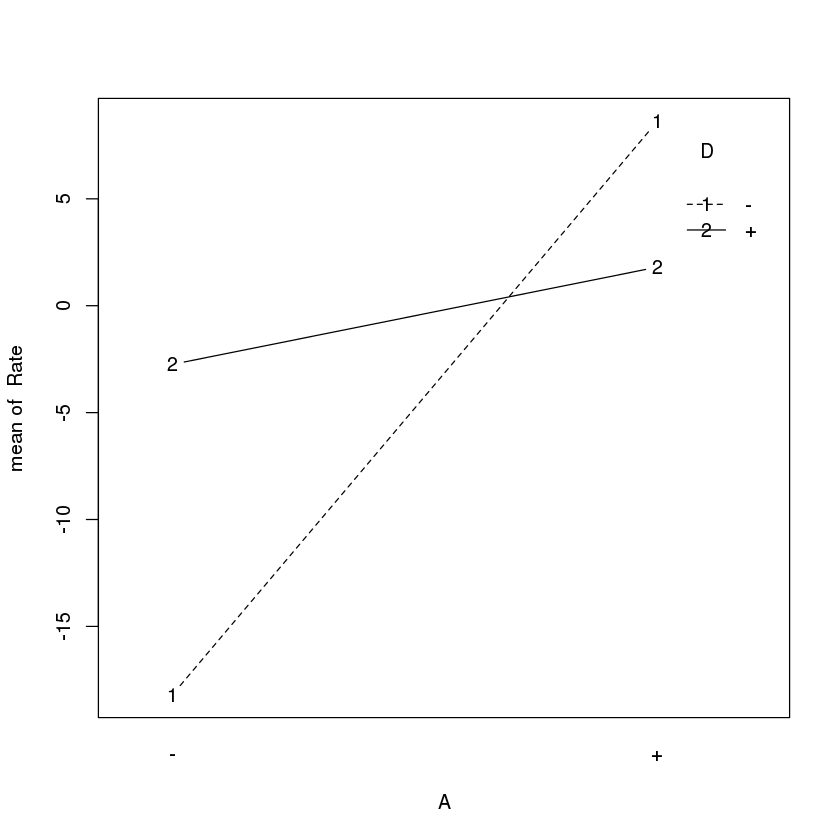

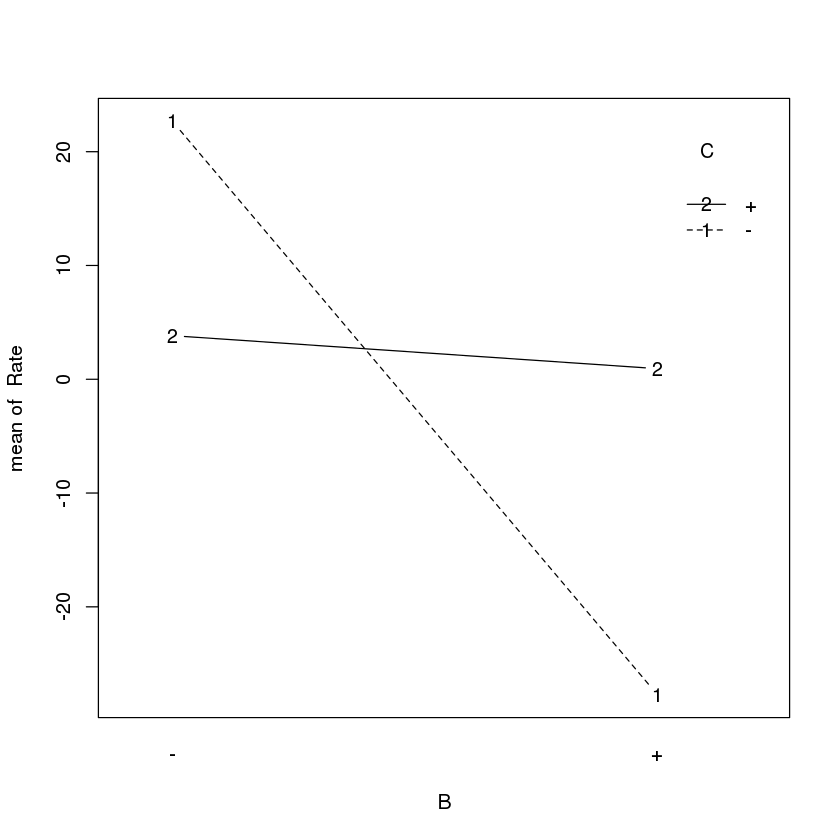

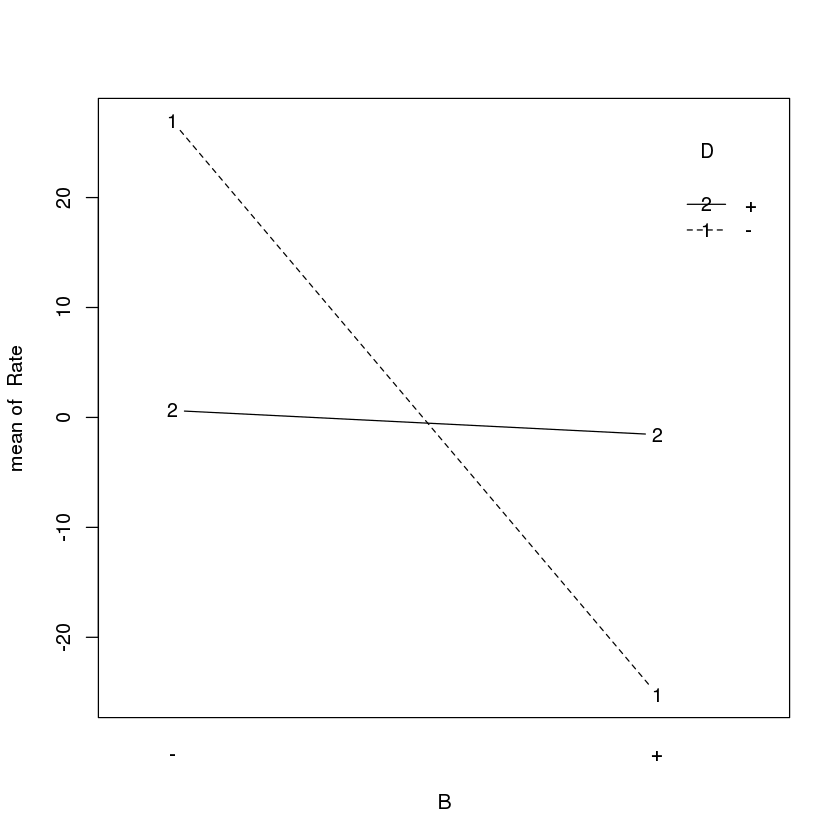

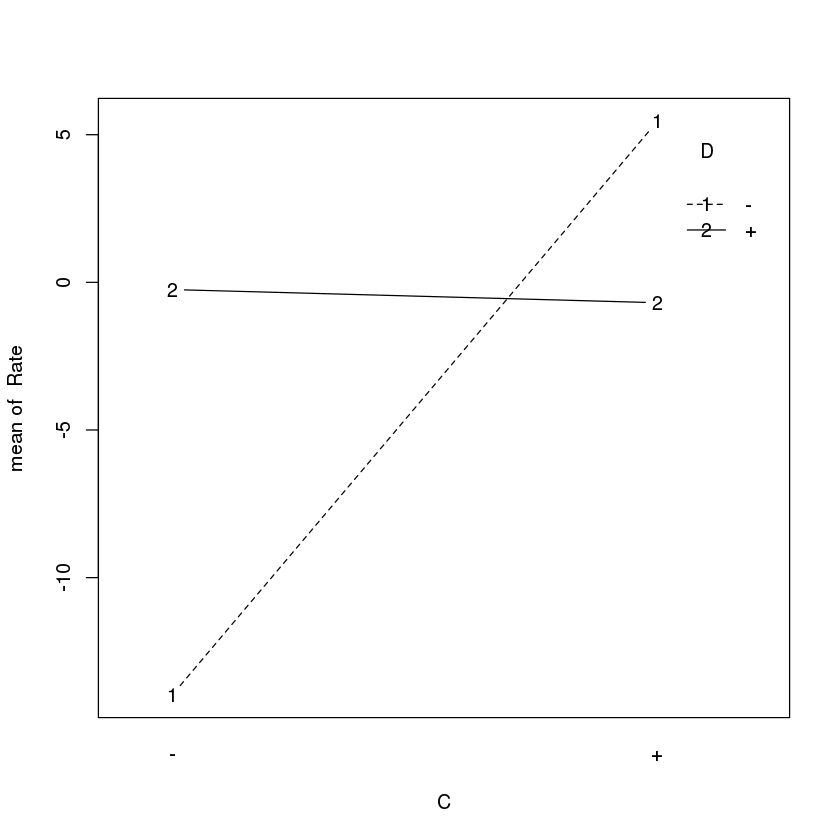

In [13]:

#################################
##     2^4    design            #
#################################
exp = read.table("./data/hw6_p17.txt", header = TRUE)
expLong=reshape(exp, varying = c("effect"), 
                 v.names = "Rate", timevar = "Effect", direction = "long")
#interaction plot
with(expLong, interaction.plot(A, B, Rate, type = "b"))
with(expLong, interaction.plot(A, C, Rate, type = "b"))
with(expLong, interaction.plot(A, D, Rate, type = "b"))
with(expLong, interaction.plot(B, C, Rate, type = "b"))
with(expLong, interaction.plot(B, D, Rate, type = "b"))
with(expLong, interaction.plot(C, D, Rate, type = "b"))


            Df Sum Sq Mean Sq F value Pr(>F)
Residuals   14  14621    1044               

            Df Sum Sq Mean Sq F value Pr(>F)
A            1    794   793.7   0.641  0.468
B            1   2207  2207.4   1.782  0.253
C            1    223   222.7   0.180  0.693
D            1     19    18.7   0.015  0.908
A:B          1   1810  1810.5   1.461  0.293
A:C          1    872   871.8   0.704  0.449
A:D          1    721   721.2   0.582  0.488
B:C          1   1102  1102.3   0.890  0.399
B:D          1   1588  1588.4   1.282  0.321
C:D          1    329   328.6   0.265  0.634
Residuals    4   4955  1238.8               

[1] 1 2

Warning message in plot.window(...):
“"full" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"full" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"full" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"full" is not a graphical parameter”Warning message in box(...):
“"full" is not a graphical parameter”Warning message in title(...):
“"full" is not a graphical parameter”

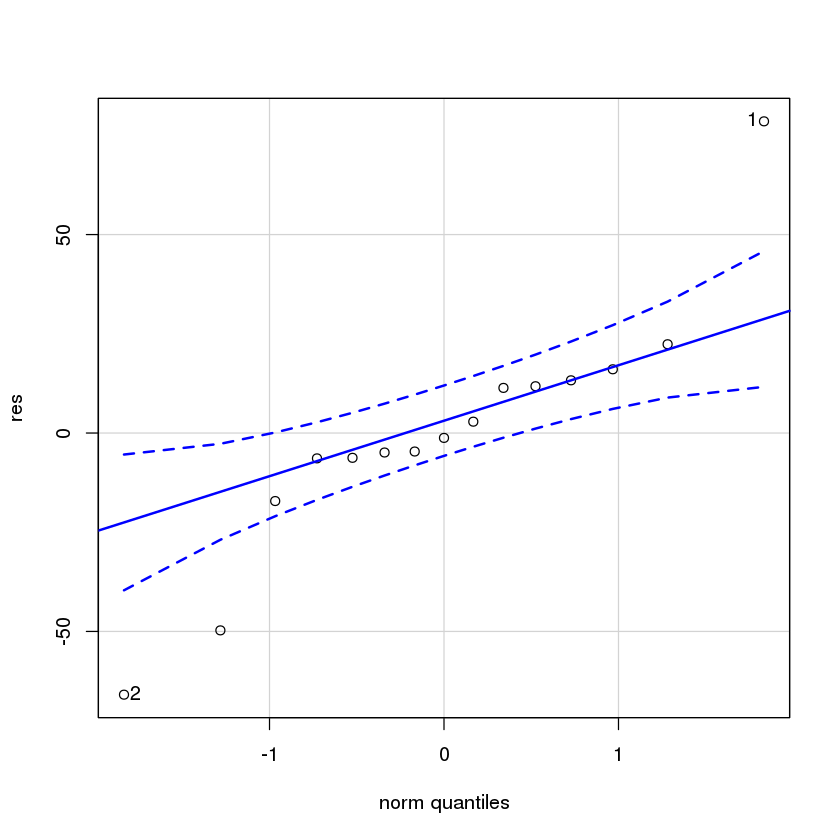

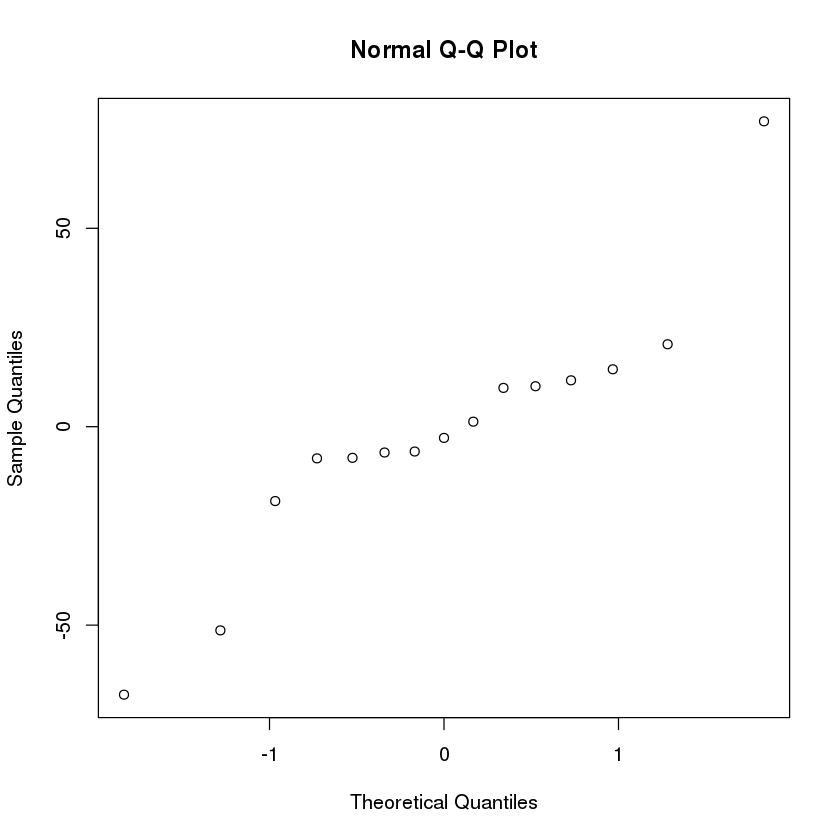

In [15]:
for (j in 1:4)
  exp[, j]=as.numeric(coded(exp[, j]))
exp.lm=lm(effect ~ A * B * C * D, exp)
exp.aov=aov(effect ~ A + B + C + D, exp)
# summary(exp.lm)
summary(exp.aov)
#using "sparsity of effects" principals
summary(aov(Rate ~ (A + B + C + D)^2, expLong))

#Diagnostic checking
res=exp$effect-fitted(exp.lm)
qqPlot(res)

#normal probability plot
qqnorm(exp$effect, full=T)


#### 6.22  
* Analyze the data from this experiment. Which facotrs sinificantly affect UEC?
* Analyze the residuals from this experiment. Are there any indications of model inadequacy?

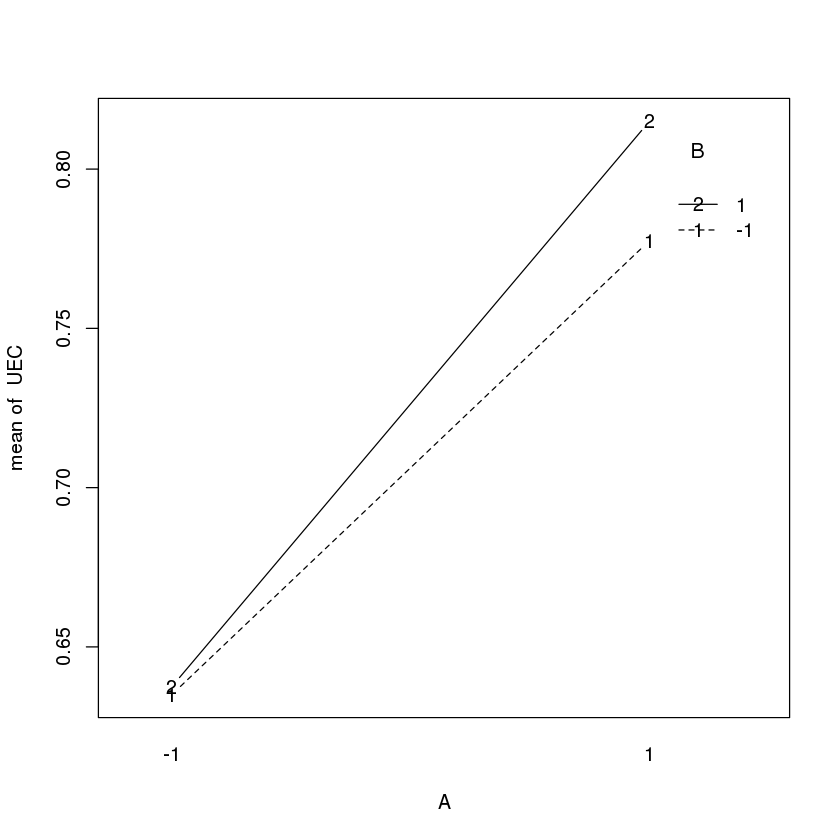

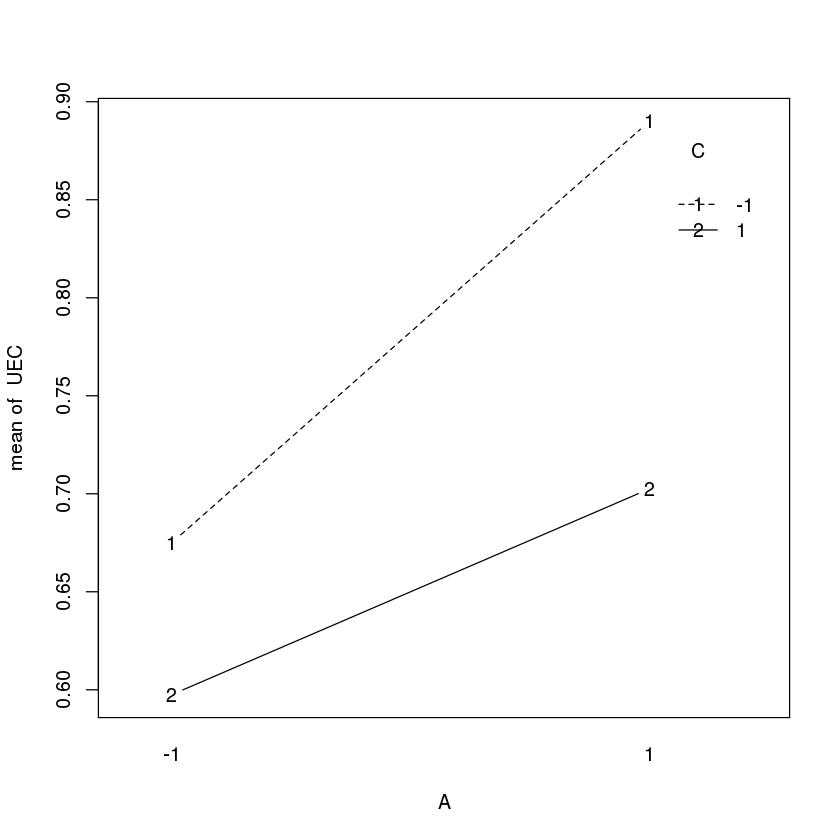

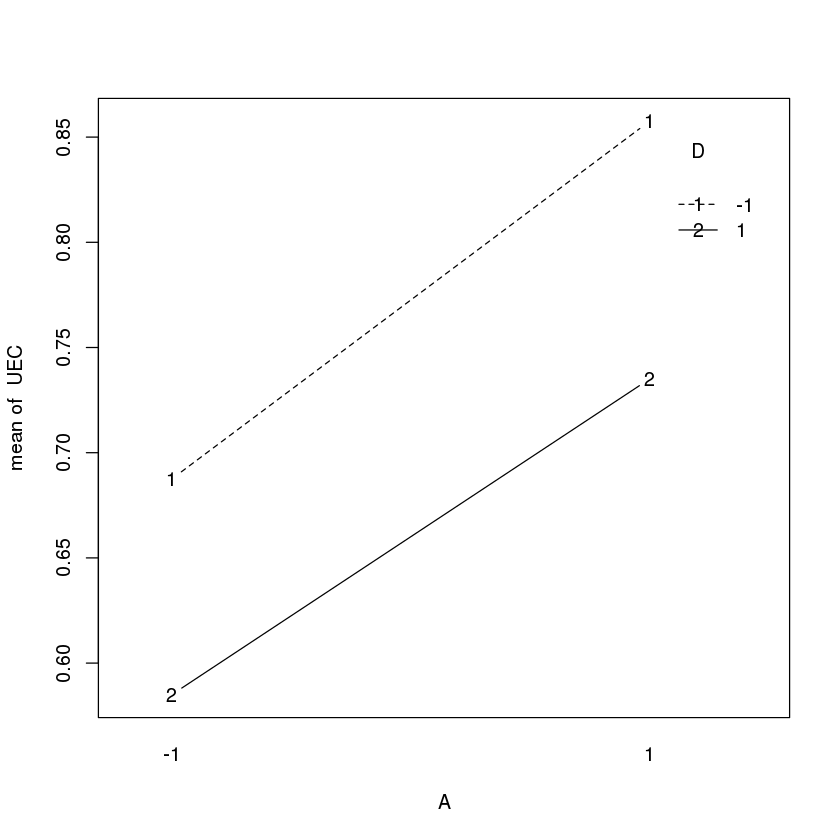

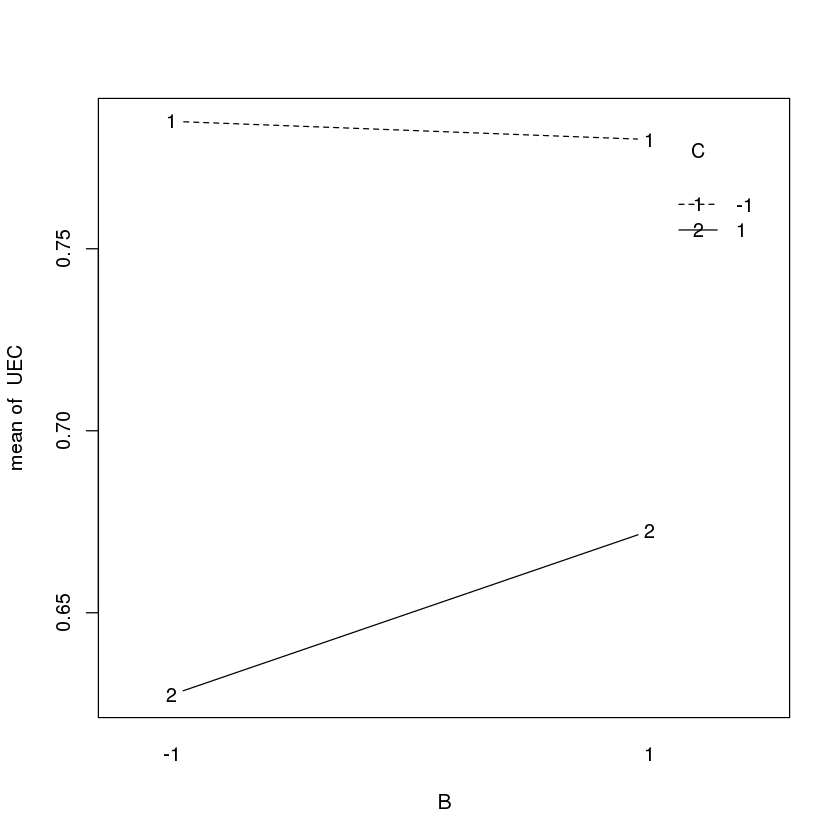

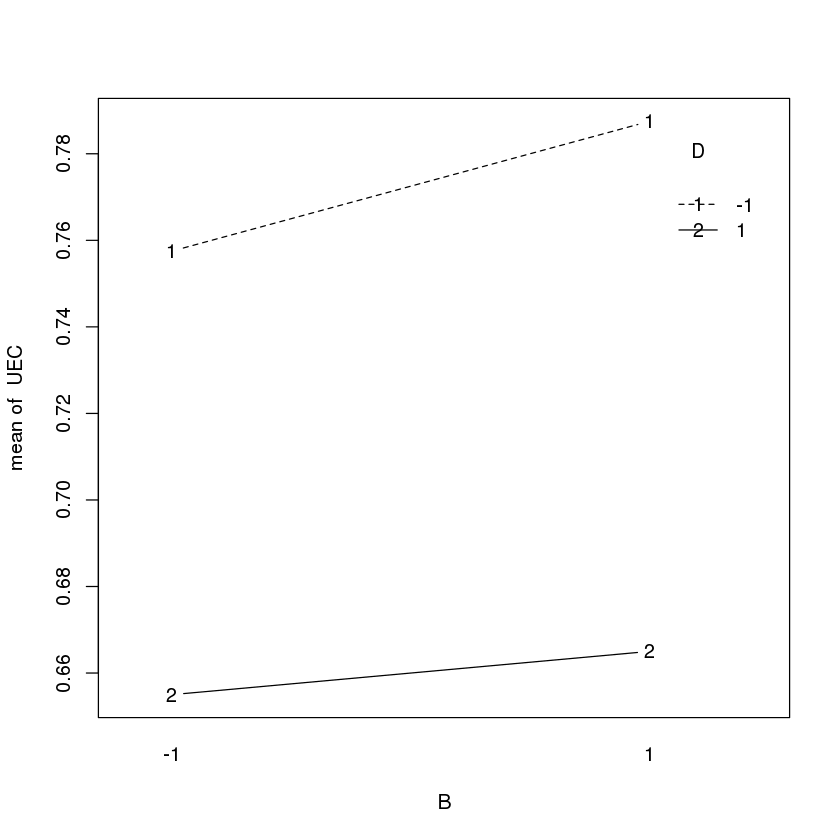

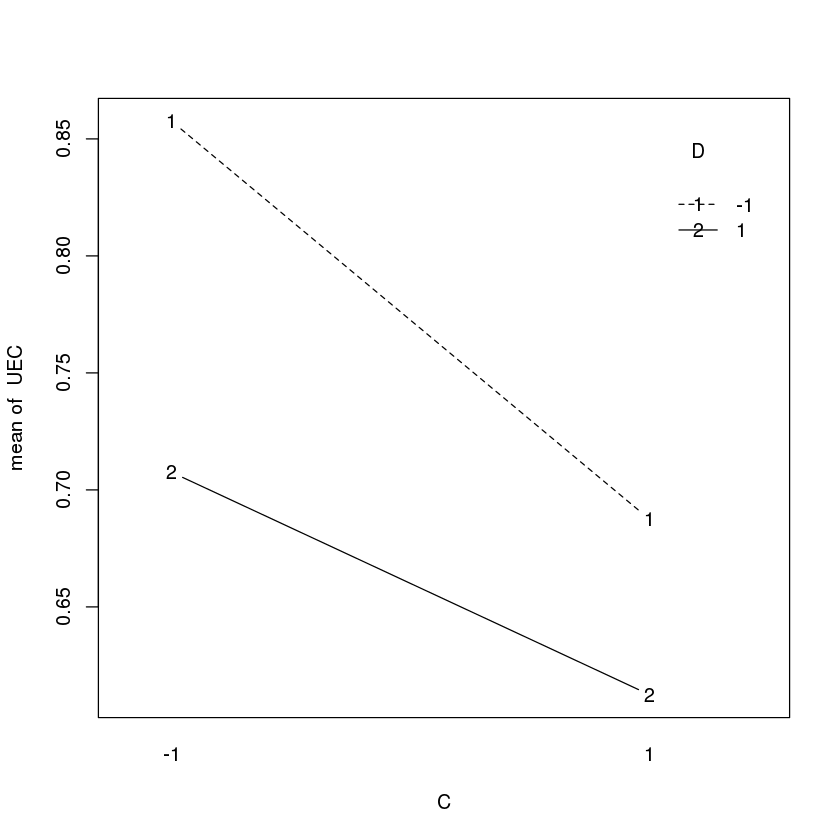

In [16]:
uec=read.table("./data/hw6_p22.txt", header = TRUE)
#interaction plot
with(uec, interaction.plot(A, B, UEC, type = "b"))
with(uec, interaction.plot(A, C, UEC, type = "b"))
with(uec, interaction.plot(A, D, UEC, type = "b"))
with(uec, interaction.plot(B, C, UEC, type = "b"))
with(uec, interaction.plot(B, D, UEC, type = "b"))
with(uec, interaction.plot(C, D, UEC, type = "b"))

            Df  Sum Sq Mean Sq F value   Pr(>F)    
A            1 0.10240 0.10240  39.213 6.16e-05 ***
B            1 0.00160 0.00160   0.613 0.450294    
C            1 0.07022 0.07022  26.892 0.000301 ***
D            1 0.05063 0.05063  19.386 0.001058 ** 
Residuals   11 0.02873 0.00261                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

            Df  Sum Sq Mean Sq F value   Pr(>F)    
A            1 0.10240 0.10240  79.073 0.000299 ***
B            1 0.00160 0.00160   1.236 0.316906    
C            1 0.07022 0.07022  54.228 0.000725 ***
D            1 0.05063 0.05063  39.093 0.001534 ** 
A:B          1 0.00123 0.00123   0.946 0.375422    
A:C          1 0.01210 0.01210   9.344 0.028207 *  
A:D          1 0.00040 0.00040   0.309 0.602318    
B:C          1 0.00250 0.00250   1.931 0.223400    
B:D          1 0.00040 0.00040   0.309 0.602318    
C:D          1 0.00562 0.00562   4.344 0.091579 .  
Residuals    5 0.00648 0.00130                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

[1] 8 7

Warning message in plot.window(...):
“"full" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"full" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"full" is not a graphical parameter”Warning message in axis(side = side, at = at, labels = labels, ...):
“"full" is not a graphical parameter”Warning message in box(...):
“"full" is not a graphical parameter”Warning message in title(...):
“"full" is not a graphical parameter”

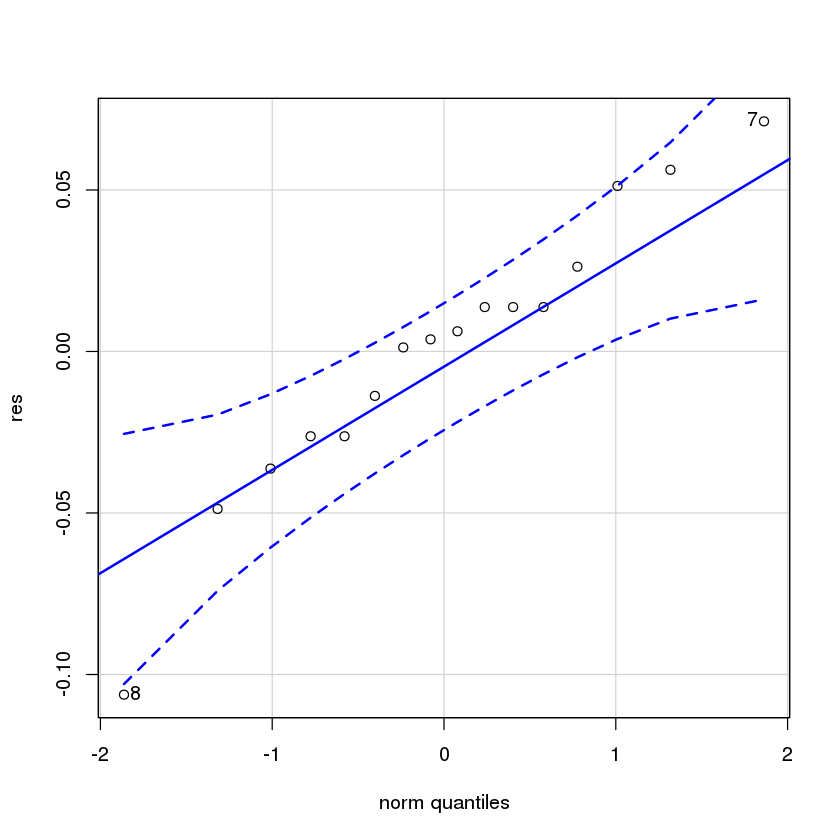

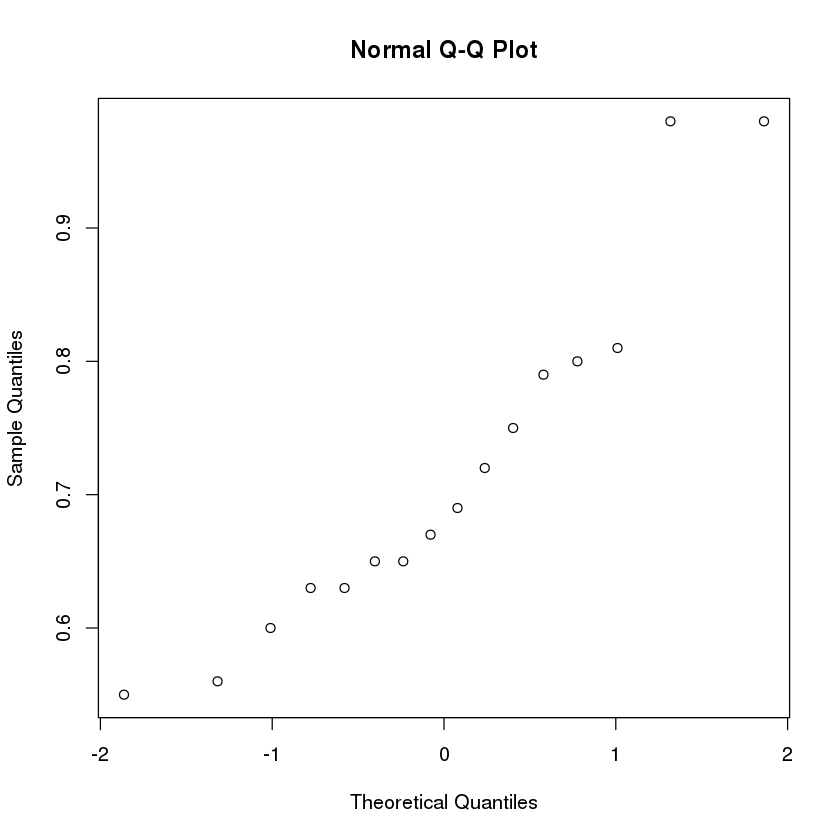

In [17]:
uec.lm=lm(UEC ~ A + B + C + D, uec)
uec.aov=aov(UEC ~ A + B + C + D, uec)
summary(uec.aov)
#using "sparsity of effects" principals
summary(aov(UEC ~ (A + B + C + D)^2, uec))

#Diagnostic checking
res=uec$UEC-fitted(uec.lm)
qqPlot(res)

#normal probability plot
qqnorm(uec$UEC, full=T)


#### 6.25. Consider the single replicate of the 2^4 design in Example 6.2. Suppose that we had arbitrarily decided to analyze the data assuming that all three- and  four-factor interaction were negligible. 
* Conduct that is analysis and compare your redults with those obtained in the example. Do you think that it is a good idea to arbitrarily assume interactions to be negligible even if they are relatively high-order ones? 

In [18]:

#filtration rate example (eg. 6.2 page 257)
filtration=read.table("./data/filtration.txt", header = TRUE)
for (j in 1:4)
  filtration[, j]=as.numeric(coded(filtration[, j]))
filt.lm=lm(Rate ~ A * B * C * D, filtration)
filt.aov=aov(Rate ~ A * B * C * D, filtration)
summary(filt.lm)
summary(filt.aov)
#using "sparsity of effects" principals
summary(aov(Rate ~ (A + B + C + D)^2, filtration))

#normal probability plot
qqnorm(filt.aov, full=T)
#or using half-normal probability plot
library("gplots")
qqnorm(filt.aov, label=T)

#perform statistical testing
filt.aov1=aov(Rate~A*C*D,filtration)
summary(filt.aov1)

#refined model
filt.lm2=lm(Rate~A+C+D+A*C+A*D,filtration)
summary(filt.lm2)

#Diagnostic checking
res=filtration$Rate-fitted(filt.lm2)
library(car)
qqPlot(res)

#Interaction plots:
with(filtration, interaction.plot(A, C, Rate))
with(filtration, interaction.plot(A, D, Rate))
with(filtration, interaction.plot(A, C * D, Rate))

#main effect plots
me_a=with(filtration, tapply(Rate,A,mean))
me_a
me_c=with(filtration, tapply(Rate,C,mean))
me_c
me_d=with(filtration, tapply(Rate,D,mean))
me_d


#generate response surface
filt.lm2=lm(Rate~A+C+D+A*C+A*D,filtration)
summary(filt.lm2)
ngrid=20
Agrid=seq(from = -1, to = 1, length = ngrid)
Cgrid=seq(from = -1, to = 1, length = ngrid)
Dgrid=seq(from = -1, to = 1, length = ngrid)

#fixed D=1
grid.ac=expand.grid(A=Agrid, C=Cgrid)
grid.ac=data.frame(grid.ac,D=rep(1,ngrid^2))
yhat.ac=matrix(predict(filt.lm2, grid.ac),ngrid,ngrid)
contour(Agrid, Cgrid, yhat.ac)
filled.contour(Agrid, Cgrid, yhat.ac,color.palette=heat.colors)

#fix A=1
grid.cd=expand.grid(C=Cgrid, D=Dgrid)
grid.cd=data.frame(grid.cd,A=rep(1,ngrid^2))
yhat.cd=matrix(predict(filt.lm2, grid.cd),ngrid,ngrid)
contour(Cgrid, Dgrid, yhat.cd)
filled.contour(Cgrid, Dgrid, yhat.cd,color.palette=heat.colors)

################################################
#   adding center points                      ##
################################################
#Filtration rate, with 4 center points
filt2=read.table("./data/filtration-with-center.txt", header = TRUE)
#full model
summary(aov(Rate ~ A * B * C * D + I(A^2) + I(B^2) + I(C^2) + I(D^2),
            filt2))
#reduced model
summary(aov(Rate ~ A * C + A * D + I(A^2) + I(C^2) + I(D^2), filt2))

#coded variable vs. engineering units
I=c(4,4,6,6,4,4,6,6)
R=c(rep(1,4),rep(2,4))
V=c(3.082, 4.013,6.065,5.992,7.934,8.159,11.865,12.138)
cI=rep(c(-1,-1,1,1),2)
cR=c(-1,-1,-1,-1,1,1,1,1)
data=data.frame(I=I, R=R,V=V,cI=cI,cR=cR)
#using coded variable, f-test t-test give identical p-values.
summary(lm(V~cI*cR,data))
summary(aov(V~cI*cR),data))
#using engineering unites
summary(lm(V~I*R,data))


ERROR: Error in parse(text = x, srcfile = src): <text>:88:27: unexpected ')'
87: summary(lm(V~cI*cR,data))
88: summary(aov(V~cI*cR),data))
                              ^
